# <font color='blue'>Mean Machine: Exploring Ensemble Methods</font>

In this notebook, we will explore the ensemble trees using the package from sklearn. The tasks herewith are to

* Use pandas to do some feature engineering.
* Train a boosted ensemble of decision-trees (gradient boosted trees) and random forest on the LendingClub dataset.
* Predict whether a loan will default along with prediction probabilities (on a validation set).
* Evaluate the trained model and compare it with a baseline.
* Find the most positive and negative loans using the learned model.
* Explore how the number of trees influences classification performance.

# <font color='red'>Import all relevant packages</font>

In [1]:
import numpy as np     # 用来做数学运算
import pandas as pd    # 用来处理数据表

# 将所有图都在 Notebook 里显示
%matplotlib inline               
import matplotlib.pyplot as plt  # 用来画图
from sklearn.model_selection import train_test_split    # 做交叉验证，划分训练集和测试集
from sklearn.tree import DecisionTreeClassifier         # 决策树分类器
from sklearn.ensemble import GradientBoostingClassifier # 提升树分类器
from sklearn.ensemble import RandomForestClassifier     # 随机森林分类器

# <font color='red'>Load Lending Club dataset</font>

In [2]:
loans = pd.read_csv('lending-club-data.csv', low_memory=False)
loans.head(3).append(loans.tail(3))

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.143500,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1,2.393200,20161201T000000,1,1,1
2,1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,...,1.0,1.0,1.0,1.0,0,8.259550,20141201T000000,1,1,1
122604,9695736,11547808,8525,8525,8525,60 months,18.25,217.65,D,D3,...,0.6,0.0,1.0,1.0,0,6.958120,20190101T000000,0,1,0
122605,9684700,11536848,22000,22000,22000,60 months,19.97,582.50,D,D5,...,1.0,1.0,0.0,1.0,0,8.961540,20190101T000000,1,0,1
122606,9604874,11457002,2000,2000,2000,36 months,7.90,62.59,A,A4,...,0.8,0.0,1.0,1.0,0,0.904916,20170101T000000,0,1,1


Let's quickly explore what the dataset looks like. First, let's print out the column names to see what features we have in this dataset.

In [3]:
loans.columns.values

array(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'is_inc_v', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc',
       'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'not_compliant', 'status', 'inactive_loans',
       'bad_loans', 'emp_length_num', 'grade_num', '

## Exploring the target column

The target column (label column) of the dataset that we are interested in is called `bad_loans`. In this column **1** means a risky (bad) loan **0** means a safe  loan.

We reassign the target to be:
* **+1** as a safe  loan, 
* **-1** as a risky (bad) loan. 

We put this in a new column called `safe_loans`.

In [4]:
# safe_loans =  1 => safe
# safe_loans = -1 => risky
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.drop('bad_loans', 1)

## Selecting features

Next we will use a subset of features that are **described in the code comments** below.

In [5]:
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies 
            'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

## Skipping observations with missing values

One common approach to coping with missing values is to **skip** observations that contain missing values.

In [6]:
num_of_all_loans = len(loans)
loans = loans[[target] + features].dropna()
num_of_na = num_of_all_loans - len(loans)

print( 'Dropping %s observations; keeping %s ' % (num_of_na, len(loans)) )

Dropping 29 observations; keeping 122578 


Fortunately, there are not too many missing values. We are retaining most of the data.

## Make sure the classes are balanced

One way to combat class imbalance is to undersample the larger class until the class distribution is approximately half and half. Here, we will undersample the larger class (safe loans) in order to balance out our dataset. This means we are throwing away many data points. We used `random_state=1` so everyone gets the same results.

In [7]:
safe_loans_raw = loans[loans[target] == +1]
risky_loans_raw = loans[loans[target] == -1]

# Since there are fewer risky loans than safe loans, find the ratio of 
# the sizes and use that percentage to undersample the safe loans.
ratio = len(risky_loans_raw)/float(len(safe_loans_raw))

risky_loans = risky_loans_raw
safe_loans = safe_loans_raw.sample(frac=ratio, random_state=1)

# Append the risky_loans with the downsampled version of safe_loans
loans_data = risky_loans.append(safe_loans)

Now, let's verify that the resulting percentage of safe and risky loans are each nearly 50%.

In [8]:
N1 = len(safe_loans)
N2 = len(risky_loans)
N = N1 + N2
print( "%% of safe loans  : %.2f%%" %(N1/N*100.0) )
print( "%% of risky loans : %.2f%%" %(N2/N*100.0) )
print( "Total number of loans in our new dataset :", N )

% of safe loans  : 50.00%
% of risky loans : 50.00%
Total number of loans in our new dataset : 46294


**Note:** There are many approaches for dealing with imbalanced data, including some where we modify the learning algorithm. These approaches are beyond the scope of this course, but some of them are reviewed in this [paper](http://ieeexplore.ieee.org/xpl/login.jsp?tp=&arnumber=5128907&url=http%3A%2F%2Fieeexplore.ieee.org%2Fiel5%2F69%2F5173046%2F05128907.pdf%3Farnumber%3D5128907 ). For this assignment, we use the simplest possible approach, where we subsample the overly represented class to get a more balanced dataset. In general, and especially when the data is highly imbalanced, we recommend using more advanced methods.

## One-hot Encoding

For scikit-learn's decision tree implementation, it requires numerical values for it's data matrix. This means you will have to turn categorical variables into binary features via one-hot encoding.

In [9]:
loans = loans_data # keep the original form

In [10]:
categorical_variables = []
for feat_name, feat_type in zip(loans_data.columns.values,loans_data.dtypes):
    if feat_type == object:
        categorical_variables.append(feat_name)

categorical_variables

['grade', 'home_ownership', 'purpose']

In [11]:
for feature in categorical_variables:
    feat_value = loans_data[feature].unique()
    loans_data_one_hot_encoded = pd.DataFrame()
    for val in feat_value:
        label = feature + '.' + val
        loans_data_one_hot_encoded[label] = loans_data[feature].apply(lambda x: 1 if x == val else 0)
    loans_data = pd.concat([loans_data, loans_data_one_hot_encoded], axis=1)
loans_data = loans_data.drop(categorical_variables,axis=1)

loans_data.head(3).append(loans_data.tail(3))

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose.other,purpose.debt_consolidation,purpose.major_purchase,purpose.credit_card,purpose.home_improvement,purpose.moving,purpose.house,purpose.medical,purpose.wedding,purpose.vacation
1,-1,0.8,1,1,1.00,2.39320,0.0,1.0,5.0,1,...,0,0,0,0,0,0,0,0,0,0
6,-1,0.4,0,5,5.55,4.57170,0.0,1.0,2.0,1,...,0,0,0,0,0,0,0,0,0,0
7,-1,1.0,1,1,18.08,9.71600,0.0,1.0,0.0,1,...,1,0,0,0,0,0,0,0,0,0
56203,1,0.2,0,3,15.77,5.55700,1.0,0.0,0.0,0,...,0,0,0,1,0,0,0,0,0,0
17572,1,0.2,0,5,13.89,7.18783,0.0,1.0,0.0,0,...,0,1,0,0,0,0,0,0,0,0
98495,1,0.6,0,9,8.14,8.60357,0.0,1.0,0.0,1,...,0,0,0,1,0,0,0,0,0,0


In [12]:
features = loans_data.columns.values
features = features[features != target]
features

array(['sub_grade_num', 'short_emp', 'emp_length_num', 'dti',
       'payment_inc_ratio', 'delinq_2yrs', 'delinq_2yrs_zero',
       'inq_last_6mths', 'last_delinq_none', 'last_major_derog_none',
       'open_acc', 'pub_rec', 'pub_rec_zero', 'revol_util',
       'total_rec_late_fee', 'int_rate', 'total_rec_int', 'annual_inc',
       'funded_amnt', 'funded_amnt_inv', 'installment', 'grade.C',
       'grade.F', 'grade.B', 'grade.D', 'grade.A', 'grade.E', 'grade.G',
       'home_ownership.RENT', 'home_ownership.OWN',
       'home_ownership.MORTGAGE', 'home_ownership.OTHER', 'purpose.car',
       'purpose.small_business', 'purpose.other',
       'purpose.debt_consolidation', 'purpose.major_purchase',
       'purpose.credit_card', 'purpose.home_improvement', 'purpose.moving',
       'purpose.house', 'purpose.medical', 'purpose.wedding',
       'purpose.vacation'], dtype=object)

In [13]:
print( "# of features (after one-hot encoding) = %s" % len(features) )

# of features (after one-hot encoding) = 44


## Split data into training and validation sets

We split the data into training and validation sets using an 80/20 split and specifying `random_state=1` so everyone gets the same results. Call the training and validation sets train_data and validation_data, respectively.

In [14]:
(train_data, validation_data) = train_test_split( loans_data, 
                             train_size=0.8, random_state=1 )
print( train_data.shape, validation_data.shape )
X = train_data[features]
Y = train_data[target]

(37035, 45) (9259, 45)


# <font color='red'>Gradient boosting and random forest classifier</font>

Gradient boosted trees and random forest are a powerful ensemble methods; they have been used to win many [Kaggle](https://www.kaggle.com/) competitions, and have been widely used in industry.  We will explore the predictive power of multiple decision trees as opposed to a single decision tree.

Now, let's use the built-in scikit learn

- gradient boosting classifier (`sklearn.ensemble.GradientBoostingClassifier`) 
- random froest classifier (`sklearn.ensemble.RandomForestClassifier`) 

to create classifier on the training data.

In [15]:
GBT_5 = GradientBoostingClassifier(n_estimators=5, max_depth=6)
GBT_5 = GBT_5.fit(X, Y)
print( GBT_5 )

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=5, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)


In [16]:
RF_5 = RandomForestClassifier(n_estimators=5, max_depth=6)
RF_5 = RF_5.fit(X, Y)
print( RF_5 )

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=5, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


## Making predictions

Let us consider a few positive and negative examples **from the validation set**. We will do the following:
* Predict whether or not a loan is likely to default.
* Predict the probability with which the loan is likely to default.

In [17]:
# Select all positive and negative examples.
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

# Select 2 examples from the validation set for positive & negative loans
sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

# Append the 4 examples into a single dataset
sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose.other,purpose.debt_consolidation,purpose.major_purchase,purpose.credit_card,purpose.home_improvement,purpose.moving,purpose.house,purpose.medical,purpose.wedding,purpose.vacation
93539,1,0.6,0,5,31.70,13.30900,0.0,1.0,0.0,0,...,0,1,0,0,0,0,0,0,0,0
10285,1,0.6,0,4,10.80,8.19823,0.0,1.0,0.0,1,...,0,1,0,0,0,0,0,0,0,0
121325,-1,0.4,0,6,23.57,6.50943,0.0,1.0,1.0,1,...,0,1,0,0,0,0,0,0,0,0
74825,-1,1.0,0,7,18.56,19.08670,0.0,1.0,0.0,1,...,0,1,0,0,0,0,0,0,0,0


## Explore label predictions and probability predictions

For each row in the **sample_validation_data**, write code to make **GBT_5** and **RF_5** predict whether or not the loan is classified as a **safe loan**. Moreover, for each row in the **sample_validation_data**, what is the probability of a loan being classified as **safe**? 

**Hint:** Use the `predict()` and `predict_proba()` method

In [18]:
Xs = sample_validation_data[features]
Ys = sample_validation_data[target]

In [19]:
print( GBT_5.predict(Xs) )
print( Ys.values )
print( GBT_5.predict(Xs) == Ys.values )
print( GBT_5.predict_proba(Xs)[:,1] )

[-1  1 -1 -1]
[ 1  1 -1 -1]
[False  True  True  True]
[ 0.45025068  0.58411689  0.3212399   0.4435304 ]


In [20]:
print( RF_5.predict(Xs) )
print( Ys.values )
print( RF_5.predict(Xs) == Ys.values )
print( RF_5.predict_proba(Xs)[:,1] )

[-1  1 -1 -1]
[ 1  1 -1 -1]
[False  True  True  True]
[ 0.47759772  0.64817725  0.31872334  0.26574128]


## Feature importance by Random Forest

Random forest can help selecting features by checking the value of importances

** Hint: ** Use the `feature_importances_` attribute

In [21]:
sort_idx = np.argsort( RF_5.feature_importances_ )
features[sort_idx[::-1]]

array(['int_rate', 'grade.A', 'total_rec_late_fee', 'annual_inc',
       'revol_util', 'payment_inc_ratio', 'grade.B', 'dti',
       'total_rec_int', 'funded_amnt_inv', 'grade.C', 'funded_amnt',
       'grade.D', 'installment', 'purpose.small_business', 'grade.G',
       'emp_length_num', 'open_acc', 'inq_last_6mths', 'last_delinq_none',
       'grade.E', 'sub_grade_num', 'last_major_derog_none',
       'purpose.major_purchase', 'short_emp', 'delinq_2yrs',
       'home_ownership.MORTGAGE', 'pub_rec', 'home_ownership.RENT',
       'pub_rec_zero', 'purpose.moving', 'home_ownership.OTHER',
       'purpose.car', 'purpose.vacation', 'purpose.home_improvement',
       'home_ownership.OWN', 'purpose.credit_card',
       'purpose.debt_consolidation', 'delinq_2yrs_zero', 'grade.F',
       'purpose.other', 'purpose.house', 'purpose.medical',
       'purpose.wedding'], dtype=object)

## Evaluating accuracy of the boosted tree model

Recall that the accuracy is defined as follows:
$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$

Evaluate the accuracy of the **GBT_5** and **RF_5** on the **validation_data**.

**Hint**: Use the `score()` method in the model.

In [22]:
print( GBT_5.score(X,Y) )
print( RF_5.score(X,Y) )

0.665883623599
0.656919130552


## Comparison with decision trees

In [23]:
DT = DecisionTreeClassifier(max_depth=6)
DT = DT.fit(X, Y)
print( DT )

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')


In [24]:
print( DT.score(X,Y) )
print( RF_5.score(X,Y) )
print( GBT_5.score(X,Y) )

0.654813014716
0.656919130552
0.665883623599


In [25]:
Xv = validation_data[features]
Yv = validation_data[target]
print( DT.score(Xv,Yv) )
print( RF_5.score(Xv,Yv) )
print( GBT_5.score(Xv,Yv) )

0.647370126364
0.647046117291
0.659574468085


## Most positive & negative loans.

In this section, we will find the loans that are most likely to be predicted **safe**. We can do this in a few steps:

* **Step 1**: Use the **RF_5** and **GBT_5** (the model with 5 trees) and make **probability predictions** for all the loans in the **validation_data**.
* **Step 2**: Add the probability predictions as a column called **predictions** into the vali (the original form of validation_data).
* **Step 3**: Sort the data (in descreasing order) by the probability predictions.

In [26]:
RF_prob = RF_5.predict_proba(Xv)[:,1]
GBT_prob = GBT_5.predict_proba(Xv)[:,1]
print( RF_prob )
print( GBT_prob )

[ 0.31872334  0.47759772  0.26574128 ...,  0.79160538  0.43567832
  0.41251674]
[ 0.3212399   0.45025068  0.4435304  ...,  0.5559367   0.46306979
  0.49426892]


In [27]:
(train, vali) = train_test_split( loans, train_size=0.8, random_state=1 )
n = 5
N = len(vali)
RF_sort_idx = np.argsort(RF_prob)
GBT_sort_idx = np.argsort(GBT_prob)
RF_prob_df = pd.DataFrame( RF_prob, index =vali.index, columns=['RF_prob'], )
GBT_prob_df = pd.DataFrame( GBT_prob, index =vali.index, columns=['GBT_prob'] )
vali= pd.concat([RF_prob_df, GBT_prob_df, vali], axis=1)
(vali.head(3)).append(vali.tail(3))

,RF_prob,GBT_prob,safe_loans,grade,sub_grade_num,short_emp,emp_length_num,home_ownership,dti,purpose,...,pub_rec,pub_rec_zero,revol_util,total_rec_late_fee,int_rate,total_rec_int,annual_inc,funded_amnt,funded_amnt_inv,installment
121325,0.318723,0.321240,-1,D,0.4,0,6,OWN,23.57,debt_consolidation,...,1.0,0.0,61.1,15.0,17.57,768.94,53000.0,8000,8000,287.50
93539,0.477598,0.450251,1,B,0.6,0,5,RENT,31.70,debt_consolidation,...,0.0,1.0,46.2,0.0,12.12,773.71,24000.0,8000,8000,266.18
74825,0.265741,0.443530,-1,C,1.0,0,7,RENT,18.56,debt_consolidation,...,0.0,1.0,64.7,0.0,17.27,2809.61,45000.0,20000,19975,715.75
29238,0.791605,0.555937,1,A,0.8,1,1,RENT,13.62,other,...,0.0,1.0,0.1,0.0,8.59,7.20,70399.0,1000,1000,31.62
46811,0.435678,0.463070,-1,B,1.0,0,4,OWN,18.33,debt_consolidation,...,0.0,1.0,43.8,0.0,13.67,759.09,55000.0,17000,16950,578.30
36413,0.412517,0.494269,-1,D,0.4,0,4,OTHER,16.09,debt_consolidation,...,0.0,1.0,37.2,0.0,14.96,2002.73,47000.0,11200,11150,388.04


In [28]:
print( 'Top 5 safe loan by random forest' )
vali[['grade','RF_prob']].iloc[ RF_sort_idx[N-n::1] ]

Top 5 safe loan by random forest


,grade,RF_prob
28055,A,0.862499
100290,A,0.862499
8014,A,0.878476
103384,A,0.878476
23207,A,0.880701


In [29]:
print( 'Top 5 safe loan by gradient boosted tree' )
vali[['grade','GBT_prob']].iloc[ GBT_sort_idx[N-n::1] ]

Top 5 safe loan by gradient boosted tree


,grade,GBT_prob
14137,A,0.66411
122346,A,0.66411
28055,A,0.66411
5657,A,0.66411
11533,A,0.66411


In [30]:
print( 'Top 5 risky loan by random forest' )
vali[['grade','RF_prob']].iloc[ RF_sort_idx[:n:] ]

Top 5 risky loan by random forest


,grade,RF_prob
16130,G,0.091763
91065,D,0.101766
118828,D,0.112941
4456,D,0.115355
47175,D,0.116528


In [31]:
print( 'Top 5 risky loan by gradient boosted tree' )
vali[['grade','GBT_prob']].iloc[ GBT_sort_idx[:n:] ]

Top 5 risky loan by gradient boosted tree


,grade,GBT_prob
30677,A,0.308491
52678,B,0.308606
25697,C,0.308606
37839,D,0.310070
24272,B,0.310796


The riskiest loan predicted by GBT is with grade A and it is not quite reasonable. We print all information regarding to that loan, and find it is classified as the RISKY loan (safe_loans = -1). The reason might be due to the unsatisfied values of other attributes

In [51]:
pd.set_option('display.max_columns', None)
print( vali.iloc[GBT_sort_idx].head(1) )

        RF_prob  GBT_prob  safe_loans grade  sub_grade_num  short_emp  \
30677  0.539827  0.308491          -1     A            0.8          1   

       emp_length_num home_ownership    dti  purpose  payment_inc_ratio  \
30677               1           RENT  12.15  wedding            1.55049   

       delinq_2yrs  delinq_2yrs_zero  inq_last_6mths  last_delinq_none  \
30677          0.0               1.0             3.0                 1   

       last_major_derog_none  open_acc  pub_rec  pub_rec_zero  revol_util  \
30677                      1       6.0      0.0           1.0        81.0   

       total_rec_late_fee  int_rate  total_rec_int  annual_inc  funded_amnt  \
30677              29.973      8.59         226.58    137004.0         5600   

       funded_amnt_inv  installment  
30677             5475       177.02  


## Effect of adding more trees

Train models with 10, 50, 100, 200, and 500 trees. Use the n_estimators parameter to control the number of trees. Remember to keep max_depth = 6

**Warning:** This could take a couple of minutes to run.

In [32]:
num_of_trees = [ 10, 50, 100, 200, 500 ]
RF_model = {}
GBT_model = {}
for tree in num_of_trees:
    RF_model[tree] = RandomForestClassifier(n_estimators=tree, max_depth=6).fit(X, Y)
    GBT_model[tree] = GradientBoostingClassifier(n_estimators=tree, max_depth=6).fit(X, Y)
    print( 'model of', tree, 'trees is done!' )

model of 10 trees is done!
model of 50 trees is done!
model of 100 trees is done!
model of 200 trees is done!
model of 500 trees is done!


In [33]:
RF_model

{10: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=6, max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
             verbose=0, warm_start=False),
 50: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=6, max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
             verbose=0, warm_start=False),
 100: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=6, max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
         

In [34]:
GBT_model

{10: GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=6,
               max_features=None, max_leaf_nodes=None,
               min_impurity_split=1e-07, min_samples_leaf=1,
               min_samples_split=2, min_weight_fraction_leaf=0.0,
               n_estimators=10, presort='auto', random_state=None,
               subsample=1.0, verbose=0, warm_start=False),
 50: GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=6,
               max_features=None, max_leaf_nodes=None,
               min_impurity_split=1e-07, min_samples_leaf=1,
               min_samples_split=2, min_weight_fraction_leaf=0.0,
               n_estimators=50, presort='auto', random_state=None,
               subsample=1.0, verbose=0, warm_start=False),
 100: GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='devian

## Compare accuracy on entire validation set

Now we will compare the predicitve accuracy of our models on the validation set. Evaluate the **accuracy** of the 10, 50, 100, 200, and 500 tree models on the **validation_data**. Use the `score()` method.

In [35]:
for tree in num_of_trees:
    print( 'The accuracy of RF of', tree, 'trees:', RF_model[tree].score(Xv,Yv) )
    
for tree in num_of_trees:
    print( 'The accuracy of GBT of', tree, 'trees:', GBT_model[tree].score(Xv,Yv) )

The accuracy of RF of 10 trees: 0.652446268496
The accuracy of RF of 50 trees: 0.656226374338
The accuracy of RF of 100 trees: 0.654822335025
The accuracy of RF of 200 trees: 0.657954422724
The accuracy of RF of 500 trees: 0.654714332001
The accuracy of GBT of 10 trees: 0.661950534615
The accuracy of GBT of 50 trees: 0.678583000324
The accuracy of GBT of 100 trees: 0.683011124311
The accuracy of GBT of 200 trees: 0.686575224106
The accuracy of GBT of 500 trees: 0.683875148504


The classification error is defined as

$$
\mbox{classification error} = 1 - \mbox{accuracy} 
$$

In this section, we will plot the **training and validation errors versus the number of trees** to get a sense of how these models are performing. We will compare the 10, 50, 100, 200, and 500 tree models.

In [36]:
def make_figure( dim, title, xlabel, ylabel, legend ):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

In order to plot the classification errors (on the **train_data** and **validation_data**) versus the number of trees, we will need lists of these accuracies, which we get by applying the method `score()`. 

**Steps to follow:**

* **Step 1:** Calculate the classification error for model on the training data (**train_data**).
* **Step 2:** Store the training errors into a list (called `training_errors`) that looks like this:
```
[train_err_10, train_err_50, ..., train_err_500]
```
* **Step 3:** Calculate the classification error of each model on the validation data (**validation_data**).
* **Step 4:** Store the validation classification error into a list (called `validation_errors`) that looks like this:
```
[validation_err_10, validation_err_50, ..., validation_err_500]
```
Once that has been completed, the rest of the code should be able to evaluate correctly and generate the plot.


Let us start with **Step 1**. Write code to compute the classification error on the **train_data** for

* RF_models: **RF_model[10]**, **RF_model[50]**, **RF_model[100]**, **RF_model[200]**, and **RF_model[500]**
* GBT_models: **GBT_model[10]**, **GBT_model[50]**, **GBT_model[100]**, **GBT_model[200]**, and **GBT_model[500]**

In [37]:
RF_training_errors = []
RF_validation_errors = []
GBT_training_errors = []
GBT_validation_errors = []
for tree in num_of_trees:
    RF_training_errors.append( 1-RF_model[tree].score(X,Y) )
    RF_validation_errors.append( 1-RF_model[tree].score(Xv,Yv) )
    GBT_training_errors.append( 1-GBT_model[tree].score(X,Y) )
    GBT_validation_errors.append( 1-GBT_model[tree].score(Xv,Yv) )

Now, we will plot the **training_errors** and **validation_errors** versus the number of trees. We will compare the 10, 50, 100, 200, and 500 tree models.

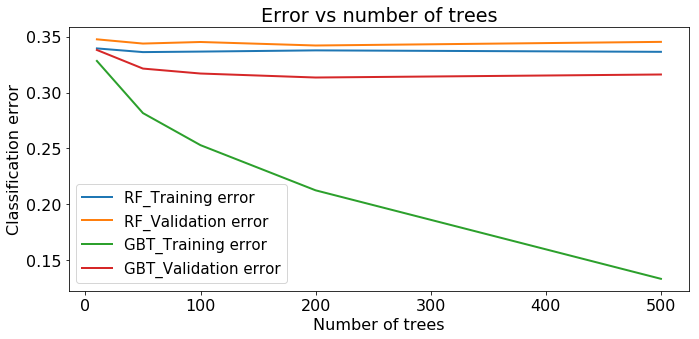

In [39]:
plt.plot(num_of_trees, RF_training_errors, linewidth=2.0, label='RF_Training error')
plt.plot(num_of_trees, RF_validation_errors, linewidth=2.0, label='RF_Validation error')
plt.plot(num_of_trees, GBT_training_errors, linewidth=2.0, label='GBT_Training error')
plt.plot(num_of_trees, GBT_validation_errors, linewidth=2.0, label='GBT_Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')